# Predicción de default financiero usando métodos de aprendizaje automático

**Estudiantes**

Federico Ocampo Ortiz, Ing. Sistemas. e-mail: federico.ocampoo@udea.edu.co

Andrés Felipe Orrego Quintero. Ing. Sistemas. e-mail: andres.orrego2@udea.edu.co

**Asesora**

Maria Bernarda Salazar Sánchez, PhD. e-mail: bernarda.salazar@udea.edu.co

## **Líbrerías y funciones**

In [24]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

# Preprocesado y modelado
# ==============================================================================
from scipy.stats import pearsonr
from scipy import stats
import math

#Separar los datos entrenamiento y prueba
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate


#Escalar Variables
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split # Separación dataset
from sklearn import metrics # Metricas para la evaluación
from sklearn.neighbors import LocalOutlierFactor


In [25]:
def draw_histograms(df, variables, n_rows, n_cols):
    fig=plt.figure(figsize=(15, 8))
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        df[var_name].hist(bins=40,ax=ax, facecolor='midnightblue', edgecolor='black')
        title_obj = ax.set_title(var_name+" Distribution")
        plt.setp(title_obj, color='black')                     # Individual title colours.

        # remove grid lines
        ax.grid(False)

        ax.xaxis.label.set_color('black')  
        ax.yaxis.label.set_color('black')          
        ax.tick_params(axis='x', colors='black')       #set the color of xticks
        ax.tick_params(axis='y', colors='black')       #set the color of yticks
        
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()


In [26]:
#Se crea un dataframe d con los datos obtenidos de archivo de entrada
# TODO: download dataset usign kaggle API
d=pd.read_csv('data/cs-training.csv')

In [27]:
# If you are using kaggle, use this to download dataset in the same folder
import os
os.system('kaggle competitions download -c GiveMeSomeCredit -p ./data')

0

## **Dataset**

In [28]:
#Se crea un dataframe d con los datos obtenidos de archivo de entrada
# TODO: download dataset usign kaggle API
d=pd.read_csv('data/cs-training.csv')
test=pd.read_csv('data/cs-test.csv')
d.head(10)

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0
5,6,0,0.213179,74,0,0.375607,3500.0,3,0,1,0,1.0
6,7,0,0.305682,57,0,5710.000000,NaN,8,0,3,0,0.0
7,8,0,0.754464,39,0,0.209940,3500.0,8,0,0,0,0.0
8,9,0,0.116951,27,0,46.000000,NaN,2,0,0,0,NaN
9,10,0,0.189169,57,0,0.606291,23684.0,9,0,4,0,2.0


### **Renombrando variables**
<br> Estas especificaciones están contenidas en la Tabla 2 del trabajo de monografía.

In [29]:
# renombramiento de variables
def rename_variables(df):
    return df.rename(
        columns={
            "RevolvingUtilizationOfUnsecuredLines": "TasaUtilizacionLineasRotativas",
            "age": "Edad",
            "NumberOfTime30-59DaysPastDueNotWorse": "Mora30a59dias",
            "DebtRatio": "RazonDeudaMensual",
            "MonthlyIncome": "IngresoMensual",
            "NumberOfOpenCreditLinesAndLoans": "CantidadCreditosActivos",
            "NumberOfTimes90DaysLate": "MoraMayorA90",
            "NumberRealEstateLoansOrLines": "CantidadCreditosDeVivienda",
            "NumberOfTime60-89DaysPastDueNotWorse": "Mora60a89dias",
            "NumberOfDependents": "CantidadDependientes",
            "SeriousDlqin2yrs": "Incumplimiento"
        }
    )
d = rename_variables(d)
test = rename_variables(test)

La primera columna de los datos de entrenamiento y validación identificada como `Unnamed: 0` corresponde a un identificador de fila que no aporta valor al modelo, por lo tanto se elimina.

In [30]:
#Borrando columnas que no se emplearán
d.drop(['Unnamed: 0'], axis='columns', inplace=True)

**Dimensiones y tipos de variables**

In [31]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 11 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Incumplimiento                  150000 non-null  int64  
 1   TasaUtilizacionLineasRotativas  150000 non-null  float64
 2   Edad                            150000 non-null  int64  
 3   Mora30a59dias                   150000 non-null  int64  
 4   RazonDeudaMensual               150000 non-null  float64
 5   IngresoMensual                  120269 non-null  float64
 6   CantidadCreditosActivos         150000 non-null  int64  
 7   MoraMayorA90                    150000 non-null  int64  
 8   CantidadCreditosDeVivienda      150000 non-null  int64  
 9   Mora60a89dias                   150000 non-null  int64  
 10  CantidadDependientes            146076 non-null  float64
dtypes: float64(4), int64(7)
memory usage: 12.6 MB


In [32]:
d.describe()

,Incumplimiento,TasaUtilizacionLineasRotativas,Edad,Mora30a59dias,RazonDeudaMensual,IngresoMensual,CantidadCreditosActivos,MoraMayorA90,CantidadCreditosDeVivienda,Mora60a89dias,CantidadDependientes
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,150000.000000,150000.000000,146076.000000
mean,0.066840,6.048438,52.295207,0.421033,353.005076,6.670221e+03,8.452760,0.265973,1.018240,0.240387,0.757222
std,0.249746,249.755371,14.771866,4.192781,2037.818523,1.438467e+04,5.145951,4.169304,1.129771,4.155179,1.115086
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.029867,41.000000,0.000000,0.175074,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.154181,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.559046,63.000000,0.000000,0.868254,8.249000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


**Histogramas**
<br> La base de datos contiene información de población entre los 20 y 80 años (distribución gausiana) con 0 personas a cargo (dependientes) en su gran mayoría, los cuales adquieren más de 2 créditos de forma simultánea (campana a la izquierda `LineasCredito`)

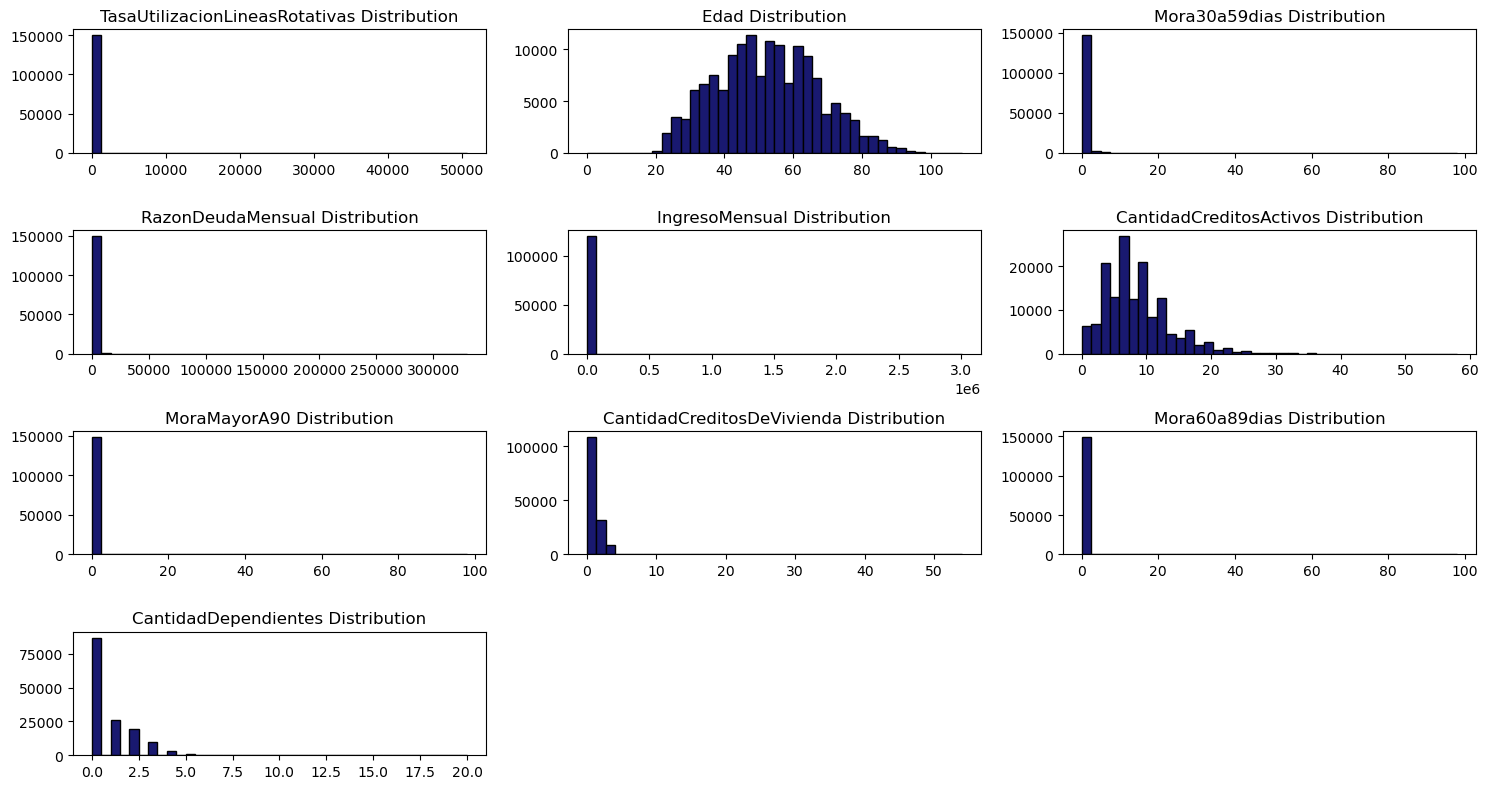

In [33]:
#Lista de variables numéricas
features = d.columns.tolist()
features.remove('Incumplimiento')

# filter d only with numCols columns
draw_histograms(d[features], d[features].columns, 4, 3)

A continuación se realiza un histograma para cada variable del dataset de prueba, con el fin de identificar la distribución de los datos y la presencia de valores atípicos. Esto también sirve para comparar la distribución de los datos de entrenamiento y validación para cada variable.

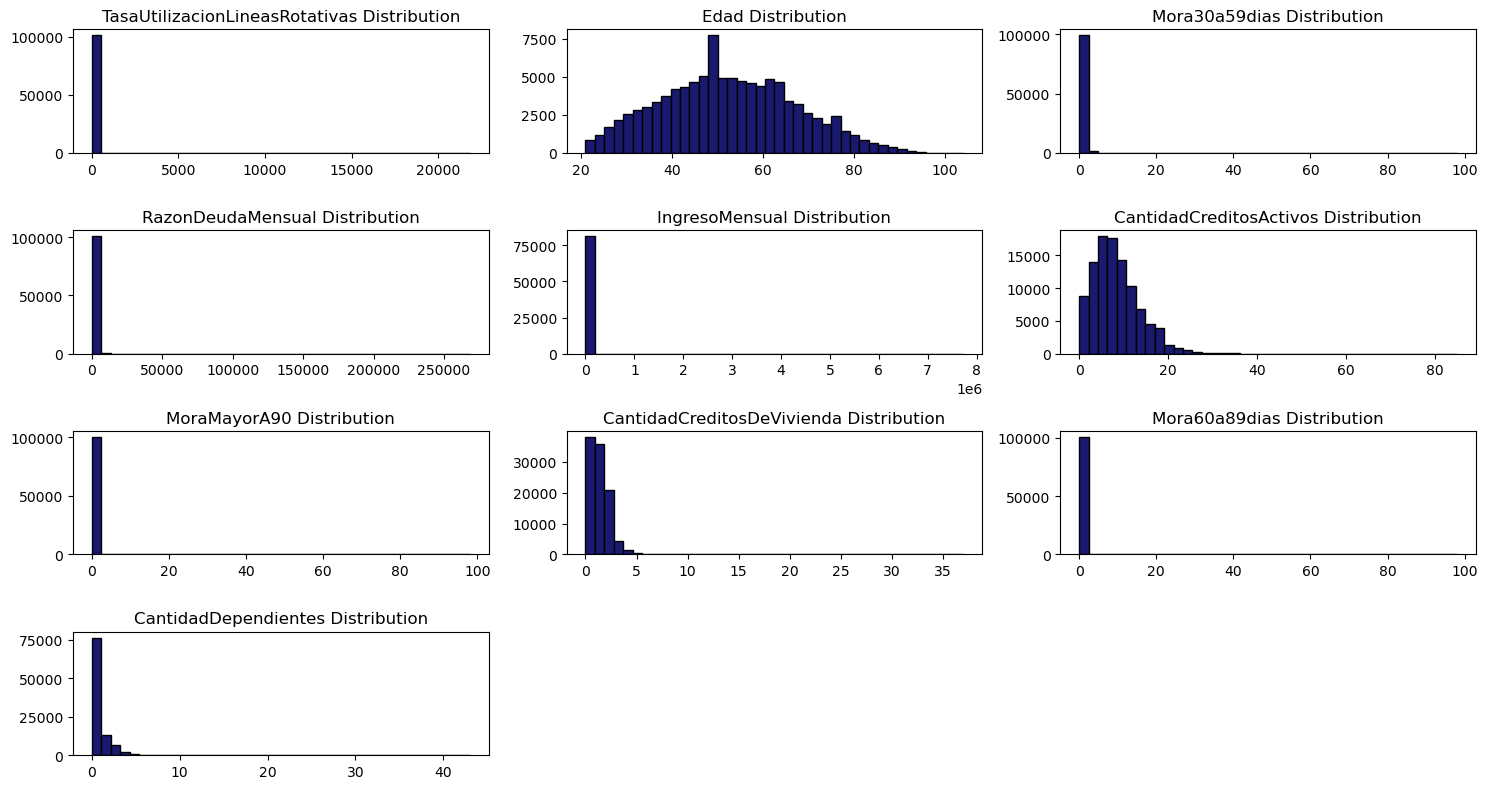

In [34]:
draw_histograms(test[features], test[features].columns, 4, 3)

### **Análisis de la relación lineal entre las variables**

La matriz de correlación permite identificar la relación lineal entre las variables, es decir, si una variable aumenta o disminuye en función de otra. En la diagonal se observa la relación de cada variable consigo misma, la cual es perfecta (1) por definición. En la parte inferior de la matriz se observa la relación entre las variables, por ejemplo, `CantidadCreditosDeVivienda` y `CantidadCreditosActivos` tienen una correlación de 0.43, lo cual indica que a medida que la cantidad de créditos aumenta, el número de créditos activos también lo hace.


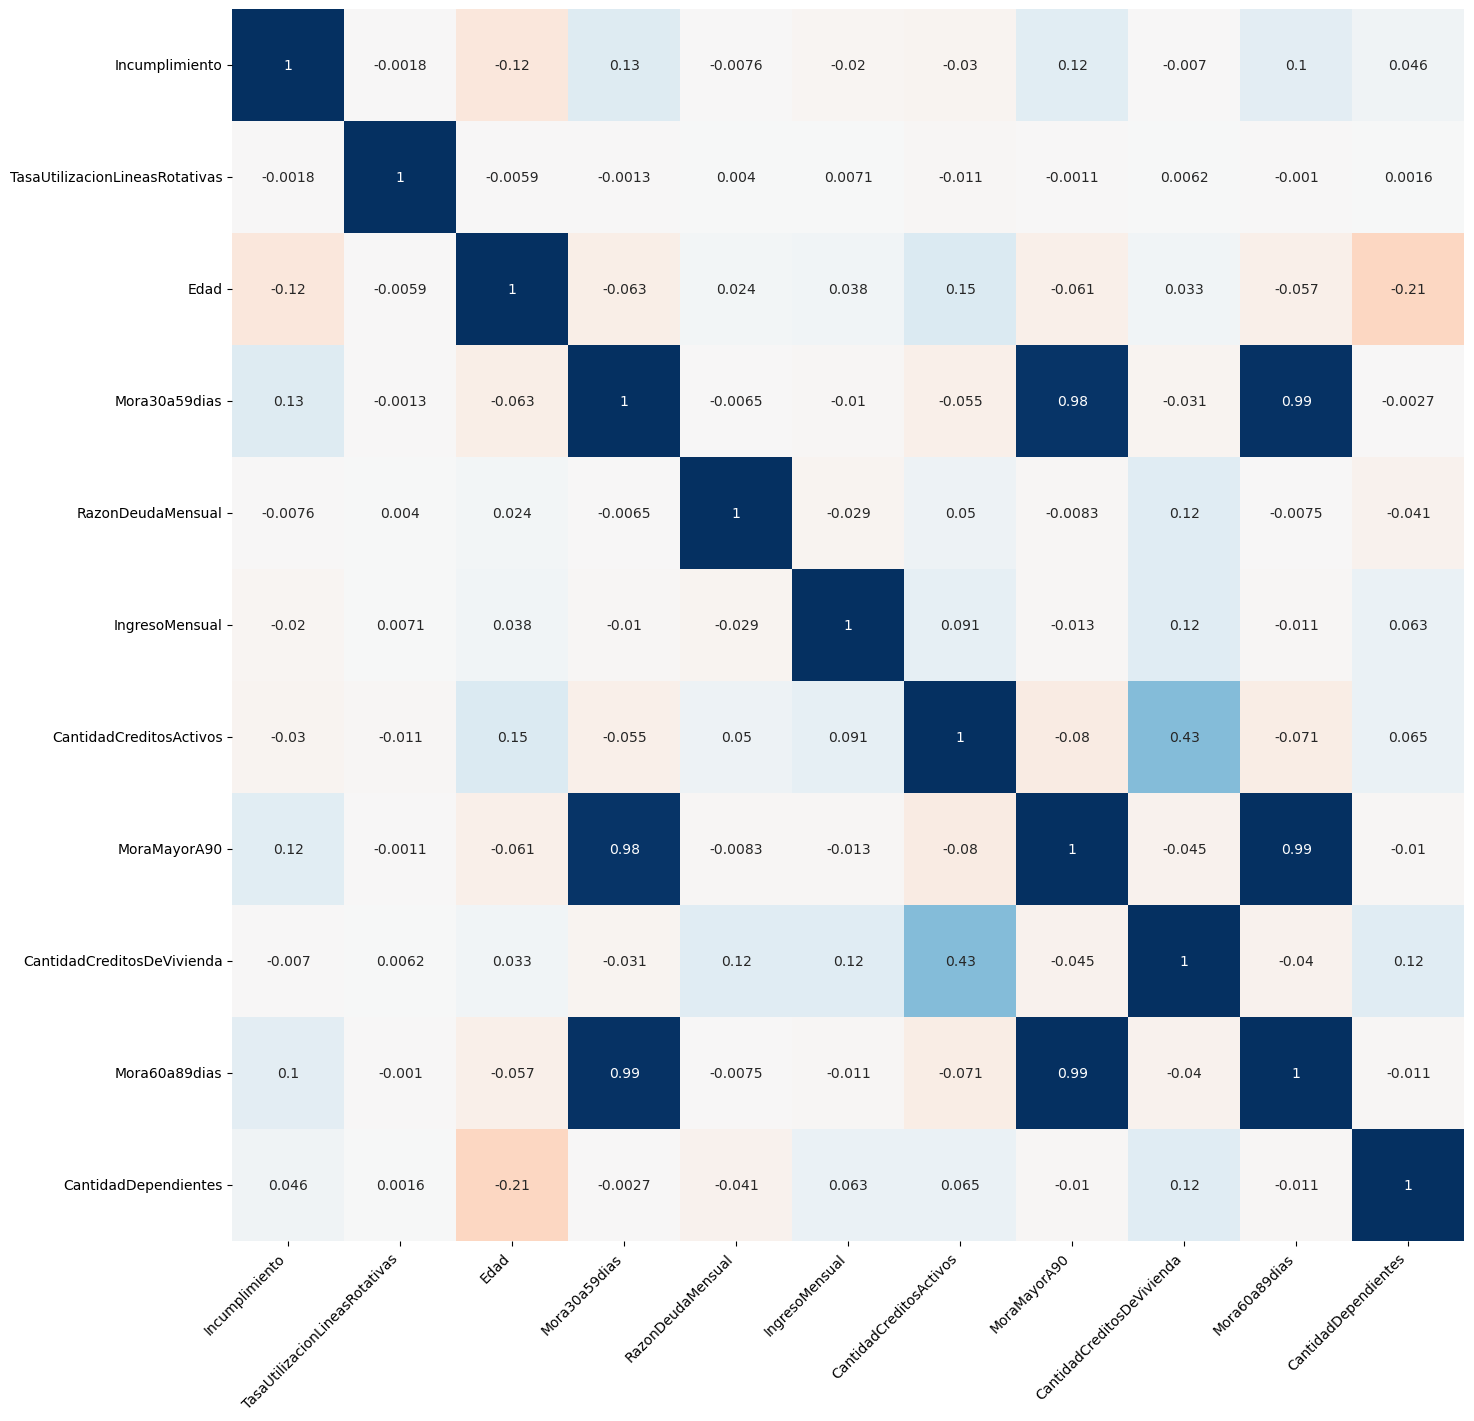

In [35]:
#Matriz de correlación
matrizCorr = d.corr()
# Mapa de calor (Heatmap) de la matriz de correlaciones
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(26, 16))

sns.heatmap(
    matrizCorr,
    annot     = True,
    cbar      = False,
    annot_kws = {"size": 10},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = 'RdBu', #sns.diverging_palette(20, 220, n=200),
    square    = True,
    ax        = ax
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right',
)

ax.tick_params(labelsize = 10)

## **Detección de atípicos**

In [36]:
def plot_histograms_variables(var, vline):
    # subplots to graph boxplots of variable TasaUtilizacionLineasRotativas
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))

    sns.boxplot(
        x = d[var],
        ax   = ax,
        color = 'blue'
    )

    ax.tick_params(labelsize = 10)
    ax.set_xlabel(
        var,
        fontsize = 10,
    )
    ax.axvline(
        x = vline,
        color = 'red',
        linestyle = '--'
    )

    fig.tight_layout()

original_size = len(d)
def count_outliers(var, df, thresh):
    outliers = df[df[var]>thresh].shape[0]
    # format print percentage with 2 decimals
    print(f"Outliers para {var}: {outliers} ({outliers/original_size:.2%})")

def remove_outliers(var, df, thresh):
    print(f"length of dataset before deleting {len(df)}")
    df = df[df[var]<=thresh]
    print(f"length of dataset after deleting {len(df)}")
    return df

### TasaUtilizacionLineasRotativas

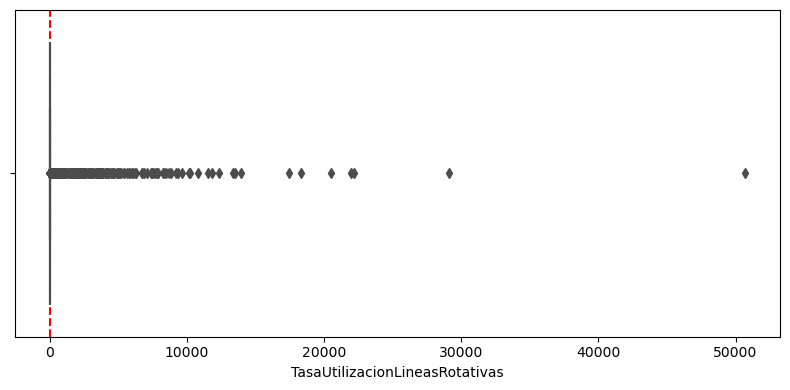

In [37]:
# boxplot de la variable TasaUtilizacionLineasRotativas no using function plot_histograms_variables
plot_histograms_variables('TasaUtilizacionLineasRotativas',1)

In [38]:
d["TasaUtilizacionLineasRotativas"].describe()

count    150000.000000
mean          6.048438
std         249.755371
min           0.000000
25%           0.029867
50%           0.154181
75%           0.559046
max       50708.000000
Name: TasaUtilizacionLineasRotativas, dtype: float64

In [39]:
count_outliers("TasaUtilizacionLineasRotativas", d, 1)

Outliers para TasaUtilizacionLineasRotativas: 3321 (2.21%)


In [40]:
d = remove_outliers("TasaUtilizacionLineasRotativas", d, 1)

length of dataset before deleting 150000
length of dataset after deleting 146679


In [41]:
d["TasaUtilizacionLineasRotativas"].describe()

count    146679.000000
mean          0.303782
std           0.337892
min           0.000000
25%           0.028608
50%           0.144476
75%           0.519980
max           1.000000
Name: TasaUtilizacionLineasRotativas, dtype: float64

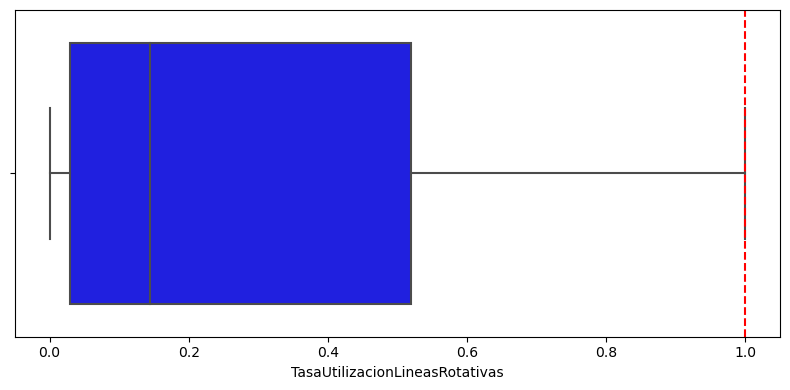

In [43]:
plot_histograms_variables('TasaUtilizacionLineasRotativas', 1)

La variable `TasaUtilizacionLineasRotativas` muestra el balance total de las tarjetas de crédito y lineas personales de crédito dividido por los cupos de estos créditos. Esto quiere decir que si una persona tiene $100 de cupo y usa $30, tendrá entonces una Tasa de utilización del 0.3. Se entiende entonces que corresponde a un porcentaje cuyos valores validos son de 0 a 1. 

Se eliminan un total de 3.321 registros detectados como outliers que corresponden al 2.21% de los datos de entrenamiento. 

### Ocurrencias de mora

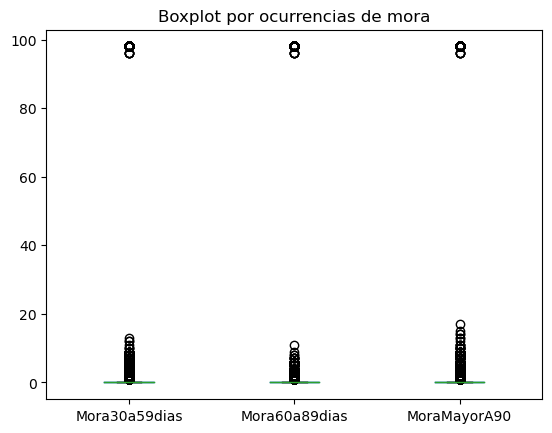

In [44]:
green_diamond = dict(markerfacecolor='g', marker='D')
fig, ax = plt.subplots()
ax.set_title('Boxplot por ocurrencias de mora')
ax.boxplot = d.boxplot(column=['Mora30a59dias', 'Mora60a89dias', 'MoraMayorA90'], grid=False)  

**Análisis de distribución de las variables categóricas para una ventana de dos años (730 días)**. Se definen como valores atípicos para esta ventana de tiempo registros cuyo valor sea superior a:
* 25 ocurrencias de mora en la ventana de 30 a 59 días
* 13 ocurrencias de mora en la ventana de 60 a 89 días

In [45]:
days_in_two_years = 365 * 2
max_possible_mora30_59 = math.ceil(days_in_two_years / 30)
print(f"Maximum value for Mora30a59: {max_possible_mora30_59}")

max_possible_mora60_89 = math.ceil(days_in_two_years / 60)
print(f"Maximum value for Mora60a89: {max_possible_mora60_89}")

count_outliers("Mora30a59dias", d, max_possible_mora30_59)
count_outliers("Mora60a89dias", d, max_possible_mora60_89)

Maximum value for Mora30a59: 25
Maximum value for Mora60a89: 13
Outliers para Mora30a59dias: 269 (0.18%)
Outliers para Mora60a89dias: 269 (0.18%)


In [46]:
d = remove_outliers("Mora30a59dias", d, max_possible_mora30_59)

length of dataset before deleting 146679
length of dataset after deleting 146410


In [47]:
d = remove_outliers("Mora60a89dias", d, max_possible_mora60_89)

length of dataset before deleting 146410
length of dataset after deleting 146410


Se encuentran entonces 269 valores atípicos para los variables `Mora30a59dias` y `Mora60a89dias`. Estos valores atípicos corresponden al 0.18% de los datos de entrenamiento. Al no ser una cantidad significativa de datos, se decide eliminarlos.

### Edad

<Axes: xlabel='Edad', ylabel='Count'>

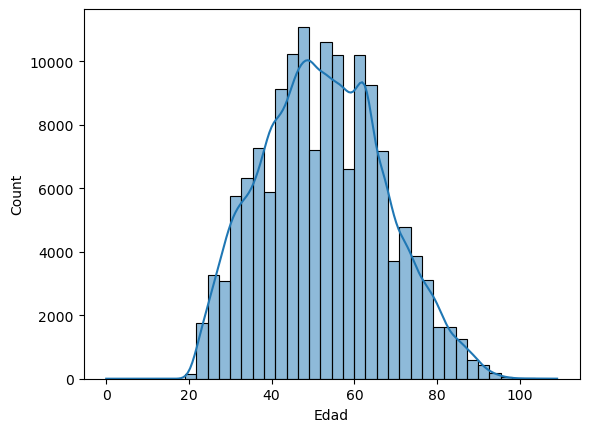

In [48]:
# histogram of variable Edad without using plot_histograms_variables function
sns.histplot(
    d['Edad'],
    bins = 40,
    kde  = True
)


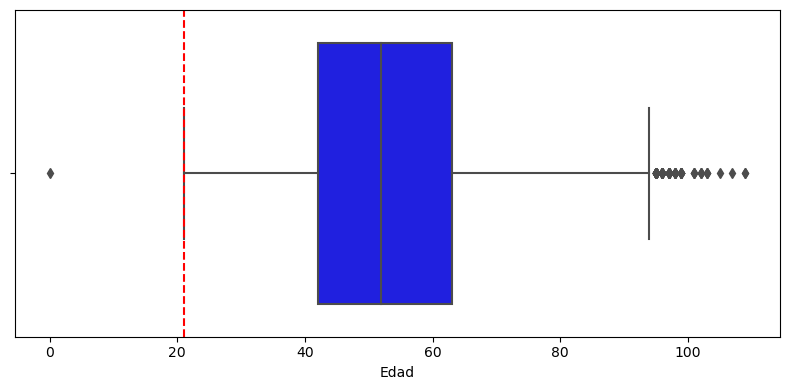

In [50]:
plot_histograms_variables("Edad", 21)

In [51]:
d["Edad"].describe()

count    146410.000000
mean         52.515272
std          14.745421
min           0.000000
25%          42.000000
50%          52.000000
75%          63.000000
max         109.000000
Name: Edad, dtype: float64

En el caso de la variable `Edad` los valores obtenidos son razonables en general. Se encuentra un único registro con `Edad` igual a cero el cual es eliminado. No es requerido más procesamiento.

In [52]:
d = d[d['Edad'] != 0]


### RazonDeudaMensual

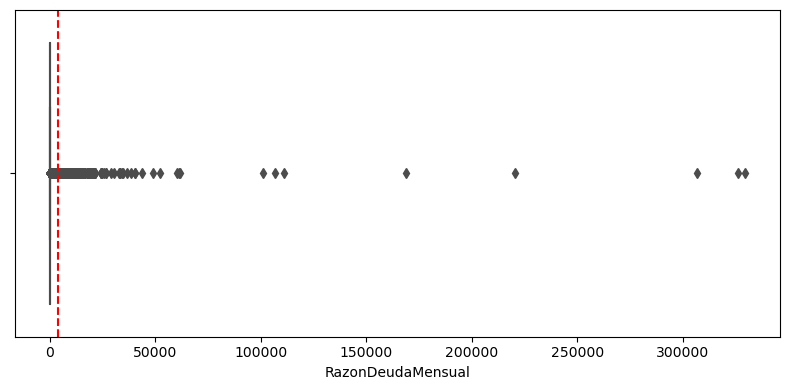

In [53]:
plot_histograms_variables("RazonDeudaMensual", 4000)




In [54]:
d["RazonDeudaMensual"].describe()

count    146409.000000
mean        356.091560
std        2057.676356
min           0.000000
25%           0.175915
50%           0.366998
75%           0.871876
max      329664.000000
Name: RazonDeudaMensual, dtype: float64

In [55]:
count_outliers("RazonDeudaMensual", d, 4000)

Outliers para RazonDeudaMensual: 2693 (1.80%)


In [56]:
d = remove_outliers("RazonDeudaMensual", d, 4000)

length of dataset before deleting 146409
length of dataset after deleting 143716


Para la variable `RazonDeudaMensual` se encuentran valores atípicos por encima de 1, que no corresponden con el tipo de dato de esta variable, que es porcentaje. En este caso un valor por encima de 1 (100%) indicaría que las deudas están por encima de los ingresos percibidos mensualmente, lo cual puede ser posible y puede representar una persona con alto riesgo de incumplimiento en el pago de sus obligaciones. Ahora esto puede ser cierto pero dependiendo del rango de los valores que tome esta variable. Si se tiene una razón de deuda mensual de 300.000, que es el máximo valor para el conjunto de entrenamiento; se estaría hablando de unas deudas mensuales equivalentes a 300.000 veces el ingreso mensual, lo cual no sería muy probable en la vida real; en caso de que ocurriese estaríamos nuevamente frente a un caso de una persona con alto riesgo de incumplimiento. 

Estos valores aunque son irreales y pueden deberse a errores en la imputación, se mantienen para el modelo ya que no se puede asegurar que no sean posibles en la vida real. Eliminarlos podría afectar el potencial del modelo. Se escoge un umbral de 4.000 para la eliminación, resultado en una eliminación de 2.693 datos atípicos que corresponden al 1.84% de los datos.

### CantidadDependientes

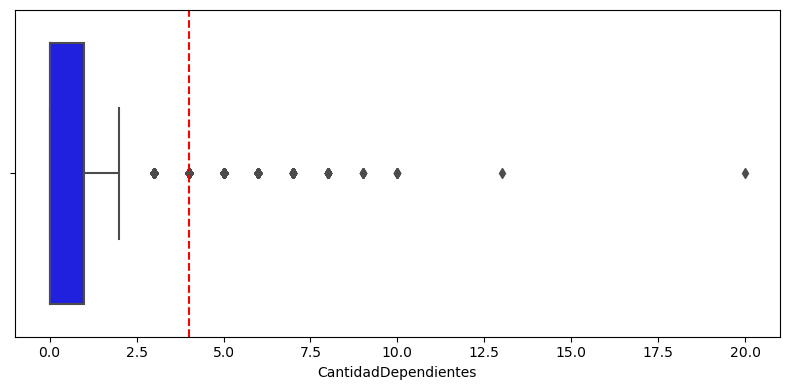

In [58]:
plot_histograms_variables("CantidadDependientes",4)

In [59]:
d['CantidadDependientes'].describe()

count    140038.000000
mean          0.757323
std           1.114088
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max          20.000000
Name: CantidadDependientes, dtype: float64

In [60]:
# count nan of CantidadDependientes
print(f"NaN values in CantidadDependientes train: {d['CantidadDependientes'].isna().sum()}")

NaN values in CantidadDependientes train: 3678


In [61]:
d["CantidadDependientes"].fillna(d["CantidadDependientes"].median(), inplace=True)

In [62]:
count_outliers("CantidadDependientes", d, 4)

Outliers para CantidadDependientes: 949 (0.63%)


In [63]:
d = remove_outliers("CantidadDependientes", d, 4)

length of dataset before deleting 143716
length of dataset after deleting 142767


Los valores nulos son imputados con la media de la característica. El número de dependientes tiene algunos valores atípicos que son eliminados, tomando como umbral 4 dependientes. Se logra una eliminación de 949 datos atípicos que corresponden al 0.66% de los datos.

### IngresoMensual

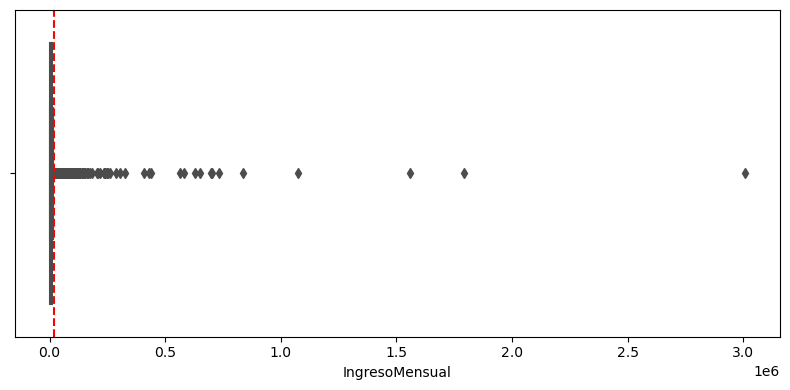

In [64]:
plot_histograms_variables("IngresoMensual", 20000)

In [65]:
# describe without cientific notation
pd.options.display.float_format = '{:.2f}'.format
d["IngresoMensual"].describe()

count    116316.00
mean       6696.92
std       14582.99
min           0.00
25%        3421.75
50%        5416.00
75%        8283.00
max     3008750.00
Name: IngresoMensual, dtype: float64

In [66]:
# count nan values for IngresoMensual
print(f"NaN values in IngresoMensual train: {d['IngresoMensual'].isna().sum()}")

NaN values in IngresoMensual train: 26451


In [67]:
d["IngresoMensual"] = d["IngresoMensual"].replace(np.nan, d["IngresoMensual"].median())


In [68]:
count_outliers('IngresoMensual', d, 20000)

Outliers para IngresoMensual: 2022 (1.35%)


In [84]:
d = remove_outliers('IngresoMensual', d, 20000)

length of dataset before deleting 142767
length of dataset after deleting 140745


El 75% de los datos para la variable `IngresoMensual` en ambos conjuntos de datos se encuentra por debajo de $10.000, lo que es un comportamiento normal. Se encuentran algunos valores atípicos como el máximo de $3.008.750 en el conjunto de entrenamiento, que es un ingreso mensual demasiado elevado y poco probable para el contexto que estamos trabajando; no tendría mucho sentido que una persona con estos ingresos mensuales tenga deudas o necesite créditos.
<br> Se encuentran 29.731 datos nulos en el conjunto de entrenamiento. Estos valores nulos son imputados con la media de la característica.
<br> Se define un umbral de 20.000 para la eliminación de valores atípicos, lo que resulta en una eliminación de 2.022 datos atípicos que corresponden al 1.45% de los datos.

### CantidadCreditosDeVivienda

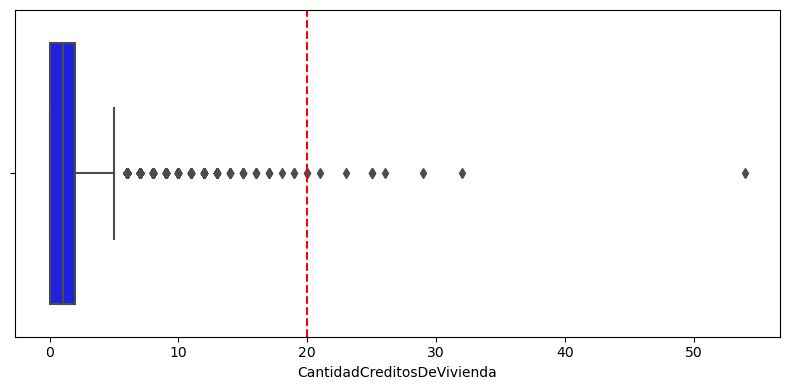

In [69]:
plot_histograms_variables("CantidadCreditosDeVivienda", 20)

In [70]:
d["CantidadCreditosDeVivienda"].describe()

count   142767.00
mean         1.00
std          1.10
min          0.00
25%          0.00
50%          1.00
75%          2.00
max         54.00
Name: CantidadCreditosDeVivienda, dtype: float64

In [71]:
thresh = 20
count_outliers('CantidadCreditosDeVivienda', d, thresh)
d = remove_outliers('CantidadCreditosDeVivienda', d, thresh)

Outliers para CantidadCreditosDeVivienda: 9 (0.01%)
length of dataset before deleting 142767
length of dataset after deleting 142758


Para la variable `CantidadCreditosDeVivienda` , que incluye la cantidad de créditos de hipoteca y lineas de crédito de vivienda, se encuentra que el 75% de los datos están dentro de los rangos esperados para esta variable. Se encuentran datos muy elevados y atípicos como 54 o 37 créditos de vivienda para una persona, lo cual no es muy probable que suceda en la vida real. Es importante resaltar que esta variable habla de la cantidad de créditos y no si los créditos están activos o vigentes, esto quiere decir que se pueda estar contando créditos ya cancelados. 
<br> Para este caso se define un umbral de 20 créditos de vivienda, lo que resulta en una eliminación de 3 datos atípicos que corresponden al 0.00% de los datos.

### CantidadCreditosActivos

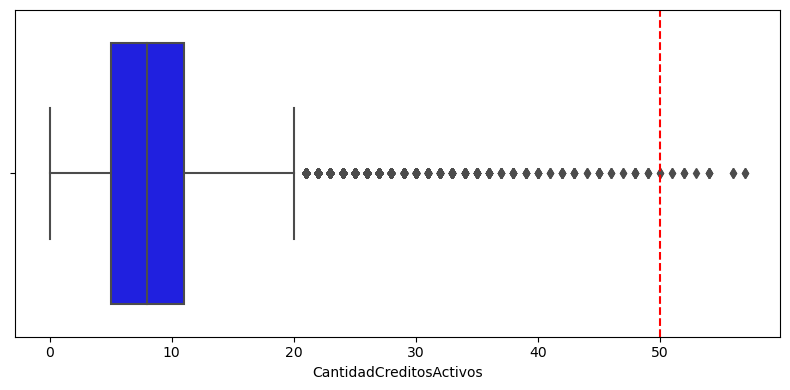

In [72]:
plot_histograms_variables("CantidadCreditosActivos",50)

In [73]:
d["CantidadCreditosActivos"].describe()

count   142758.00
mean         8.45
std          5.12
min          0.00
25%          5.00
50%          8.00
75%         11.00
max         57.00
Name: CantidadCreditosActivos, dtype: float64

In [74]:
thresh = 50
count_outliers('CantidadCreditosActivos', d, thresh)

Outliers para CantidadCreditosActivos: 14 (0.01%)


En esta variable se encuentran datos que podrían considerarse atípicos, sin embargo, se mantienen dado que pueden suceder en la vida real. Sería normal que una persona tenga 30 o 40 prestamos activos y que esté pagando todos sus créditos de forma normal con los ingresos que percibe. Por esta razón se decide mantener estos datos y no realizar eliminación de atípicos para esta variable.

### Conclusiones
- En esta revisión inicial de los datos se encuentra que casí todas las variables presentan datos atípicos.
- Se definen unos umbrales basados en la definición de las variables y los valores esperados y se hace la eliminación de atípicos de manera que no afecte mucho la cantidad de datos. 
- Después de la eliminación de atípicos, se pasa de 150.000 muestras a 140.732 muestras, lo que corresponde a una eliminación del 0.94% de los datos.

Después de la eliminación de atípicos en el siguiente histograma se describe la nueva distribución de los datos.

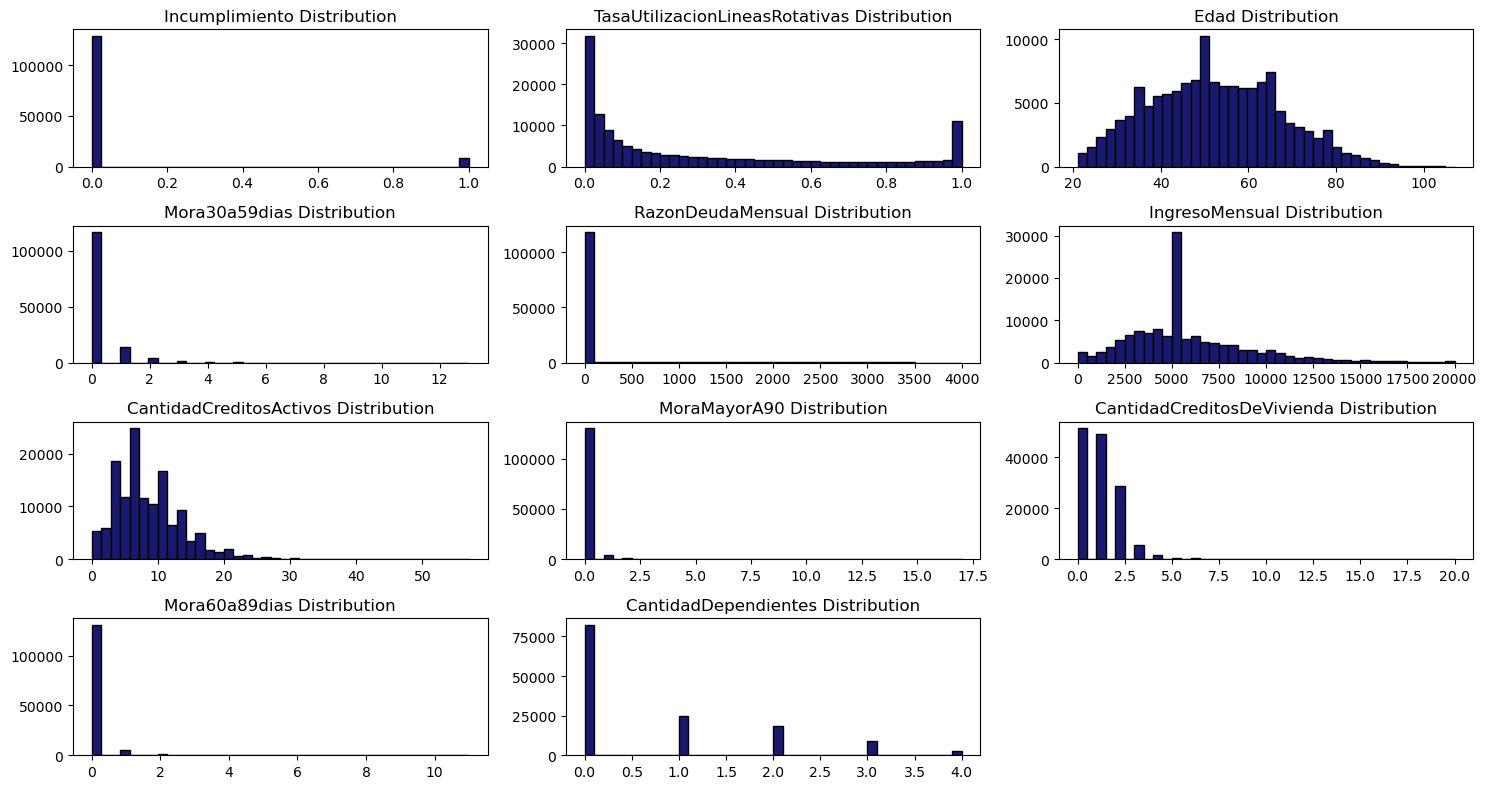

In [235]:
draw_histograms(d, d.columns, 4, 3)

## Cálculo de la **nueva variable** `OcurrenciasMora`
<br>Esta variable es la suma de las ocurrencias de mora en las ventanas de 30 a 59 días, 60 a 89 días y mayor a 90 días para cada registro.

In [92]:
# calculate new variable with the number of moras
d['OcurrenciasMora'] = d['Mora30a59dias'] + d['Mora60a89dias'] + d['MoraMayorA90']

d['OcurrenciasMora'].describe()

count    140742.000000
mean          0.361442
std           1.016653
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          19.000000
Name: OcurrenciasMora, dtype: float64

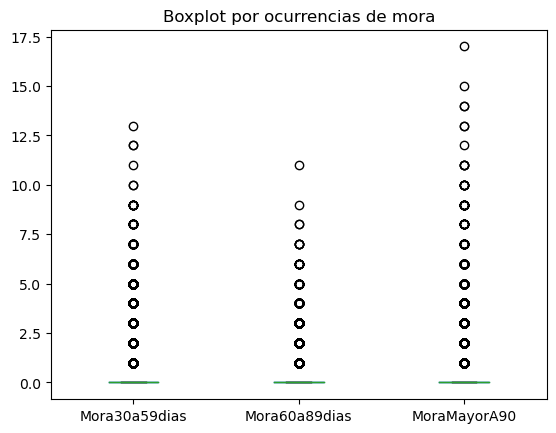

In [93]:
green_diamond = dict(markerfacecolor='g', marker='D')
fig, ax = plt.subplots()
ax.set_title('Boxplot por ocurrencias de mora')
ax.boxplot = d.boxplot(column=['Mora30a59dias', 'Mora60a89dias', 'MoraMayorA90'], grid=False)  

Análisis de la relación lineal **POS eliminación de atípicos ocurrencias por mora**

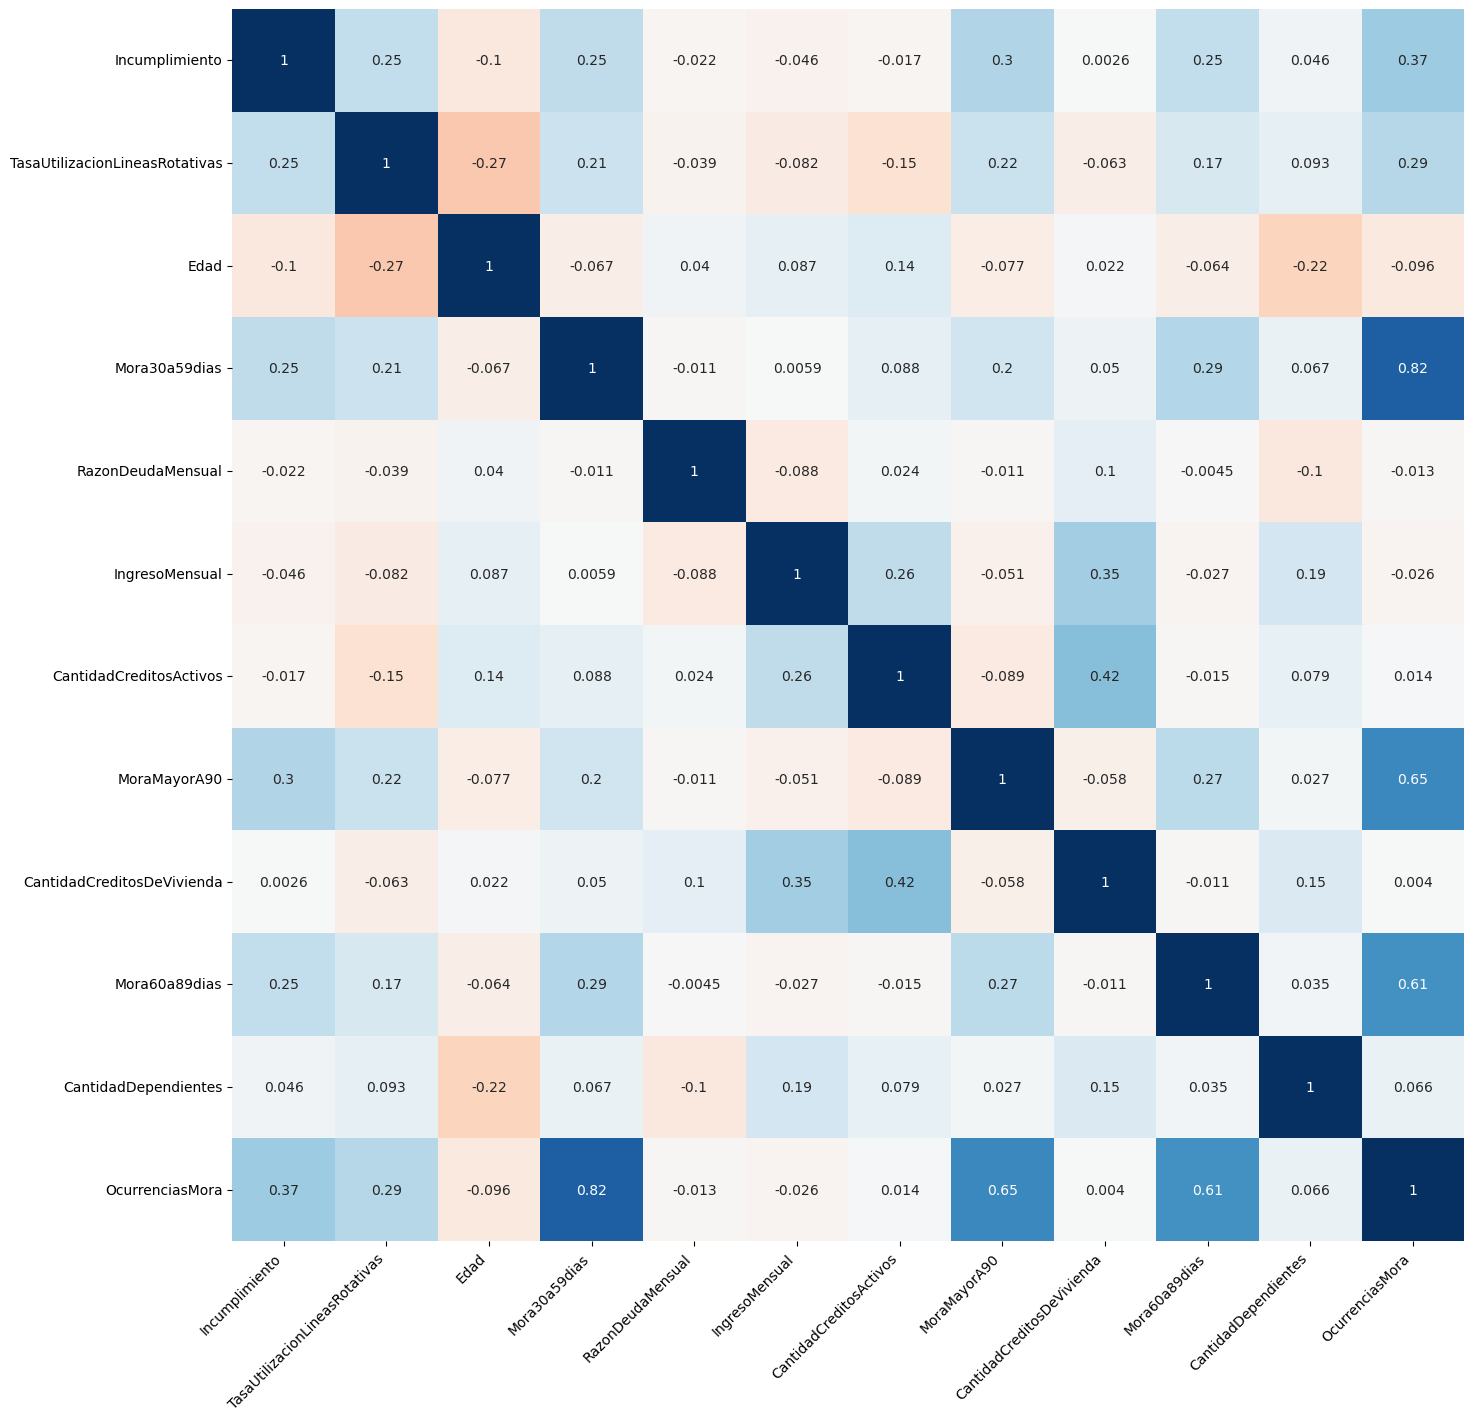

In [94]:
#Matriz de correlación
matrizCorr = d.corr()
# Mapa de calor (Heatmap) de la matriz de correlaciones
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(26, 16))

sns.heatmap(
    matrizCorr,
    annot     = True,
    cbar      = False,
    annot_kws = {"size": 10},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = 'RdBu', #sns.diverging_palette(20, 220, n=200),
    square    = True,
    ax        = ax
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right',
)

ax.tick_params(labelsize = 10)

Al eliminar los valores atípicos de las variables temporales `Mora30a59dias` y `Mora60a89dias` se puede observar como se redefine la relación lineal entre las variables, pasando de ~0.98 a ~0.20. Sin embargo, se sigue evidenciando que estas variables tienen una correlación más alta en comparación con las demás variables en la base de datos.
<br> También se puede evidenciar que en general las variables analizadas no están directamente correlacionadas con la variable de interés para la clasificación (`Incumplimiento`), se obtienen valores de correlación menores a 0.31 en todos los casos.

### **Atípicos utilizando LOF**

Eliminación de valores atípicos utilizando el método Detección de valores atípicos con Local Outlier Factor [(LOF)](https://qu4nt.github.io/sklearn-doc-es/auto_examples/neighbors/plot_lof_outlier_detection.html). La puntuación de anomalía de cada muestra se denomina Factor de Anomalía Local. Mide la desviación local de la densidad de una muestra dada con respecto a sus vecinos. Es local en el sentido de que el valor de la anomalía depende de lo aislado que esté el objeto con respecto al vecindario circundante. Más concretamente, la localidad viene dada por los k vecinos más cercanos, cuya distancia se utiliza para estimar la densidad local. Comparando la densidad local de una muestra con las densidades locales de sus vecinos, se pueden identificar las muestras que tienen una densidad sustancialmente menor que sus vecinos. Estas se consideran valores atípicos.

In [95]:
# crear un objeto LocalOutlierFactor con n_neighbors=14
lof = LocalOutlierFactor(n_neighbors=2, algorithm='auto', contamination='auto', metric='euclidean')

y_pred = lof.fit_predict(d[features])
ground_truth = np.ones(len(d[features]), dtype=int)
outliers = y_pred != ground_truth
#outliers = y_pred == -1
print(f"Valores atípicos detectados: { (y_pred != ground_truth).sum()}")
#print(f"Valores atípicos detectados: {np.count_nonzero(outliers)}")
#print('Indices de valores atípicos: ', d[outliers].index.tolist())

Valores atípicos detectados: 13616


In [96]:
df = d[~outliers]

In [97]:
print(f"length of dataset before deleting {len(d)}")
print(f"length of dataset after deleting {len(df)}")

length of dataset before deleting 140742
length of dataset after deleting 127126


(0.0, 20.0)

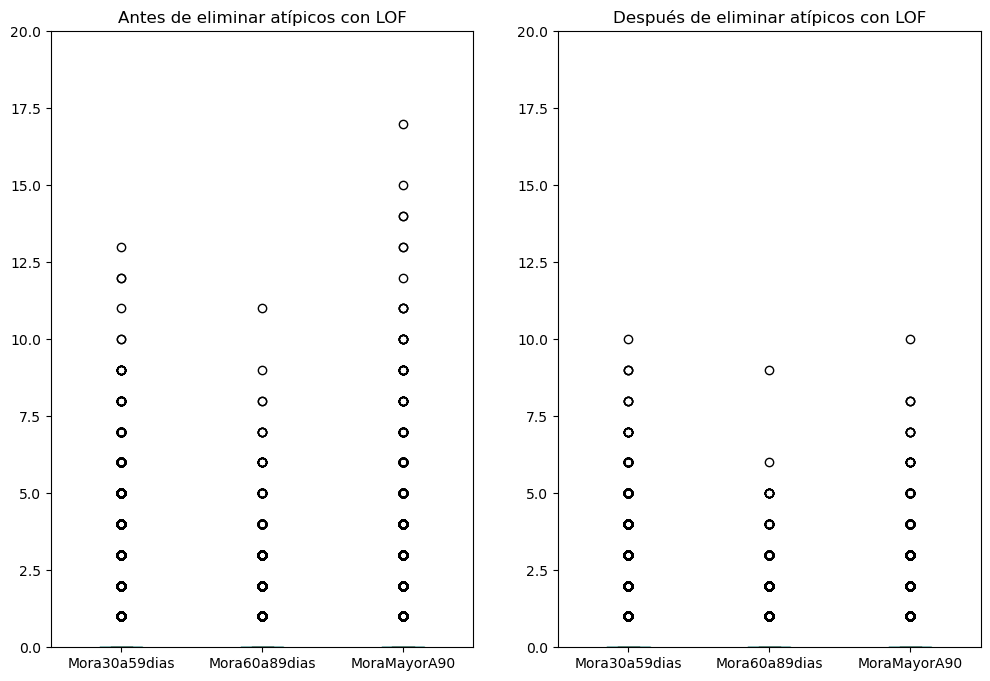

In [98]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
sns.boxplot = d.boxplot(column=['Mora30a59dias', 'Mora60a89dias', 'MoraMayorA90'],ax=ax[0],grid=False)  
ax[0].set_title('Antes de eliminar atípicos con LOF')
ax[0].set_ylim(0,20)
sns.boxplot = df.boxplot(column=['Mora30a59dias', 'Mora60a89dias', 'MoraMayorA90'],ax=ax[1],grid=False)  
ax[1].set_title('Después de eliminar atípicos con LOF')
ax[1].set_ylim(0,20)

Considero que no debemos eliminar atípicos, al menos no en estas variables temporales

Incumplimiento                       Axes(0.125,0.11;0.0545775x0.77)
TasaUtilizacionLineasRotativas    Axes(0.190493,0.11;0.0545775x0.77)
Edad                              Axes(0.255986,0.11;0.0545775x0.77)
Mora30a59dias                     Axes(0.321479,0.11;0.0545775x0.77)
RazonDeudaMensual                 Axes(0.386972,0.11;0.0545775x0.77)
IngresoMensual                    Axes(0.452465,0.11;0.0545775x0.77)
CantidadCreditosActivos           Axes(0.517958,0.11;0.0545775x0.77)
MoraMayorA90                      Axes(0.583451,0.11;0.0545775x0.77)
CantidadCreditosDeVivienda        Axes(0.648944,0.11;0.0545775x0.77)
Mora60a89dias                     Axes(0.714437,0.11;0.0545775x0.77)
CantidadDependientes               Axes(0.77993,0.11;0.0545775x0.77)
OcurrenciasMora                   Axes(0.845423,0.11;0.0545775x0.77)
dtype: object

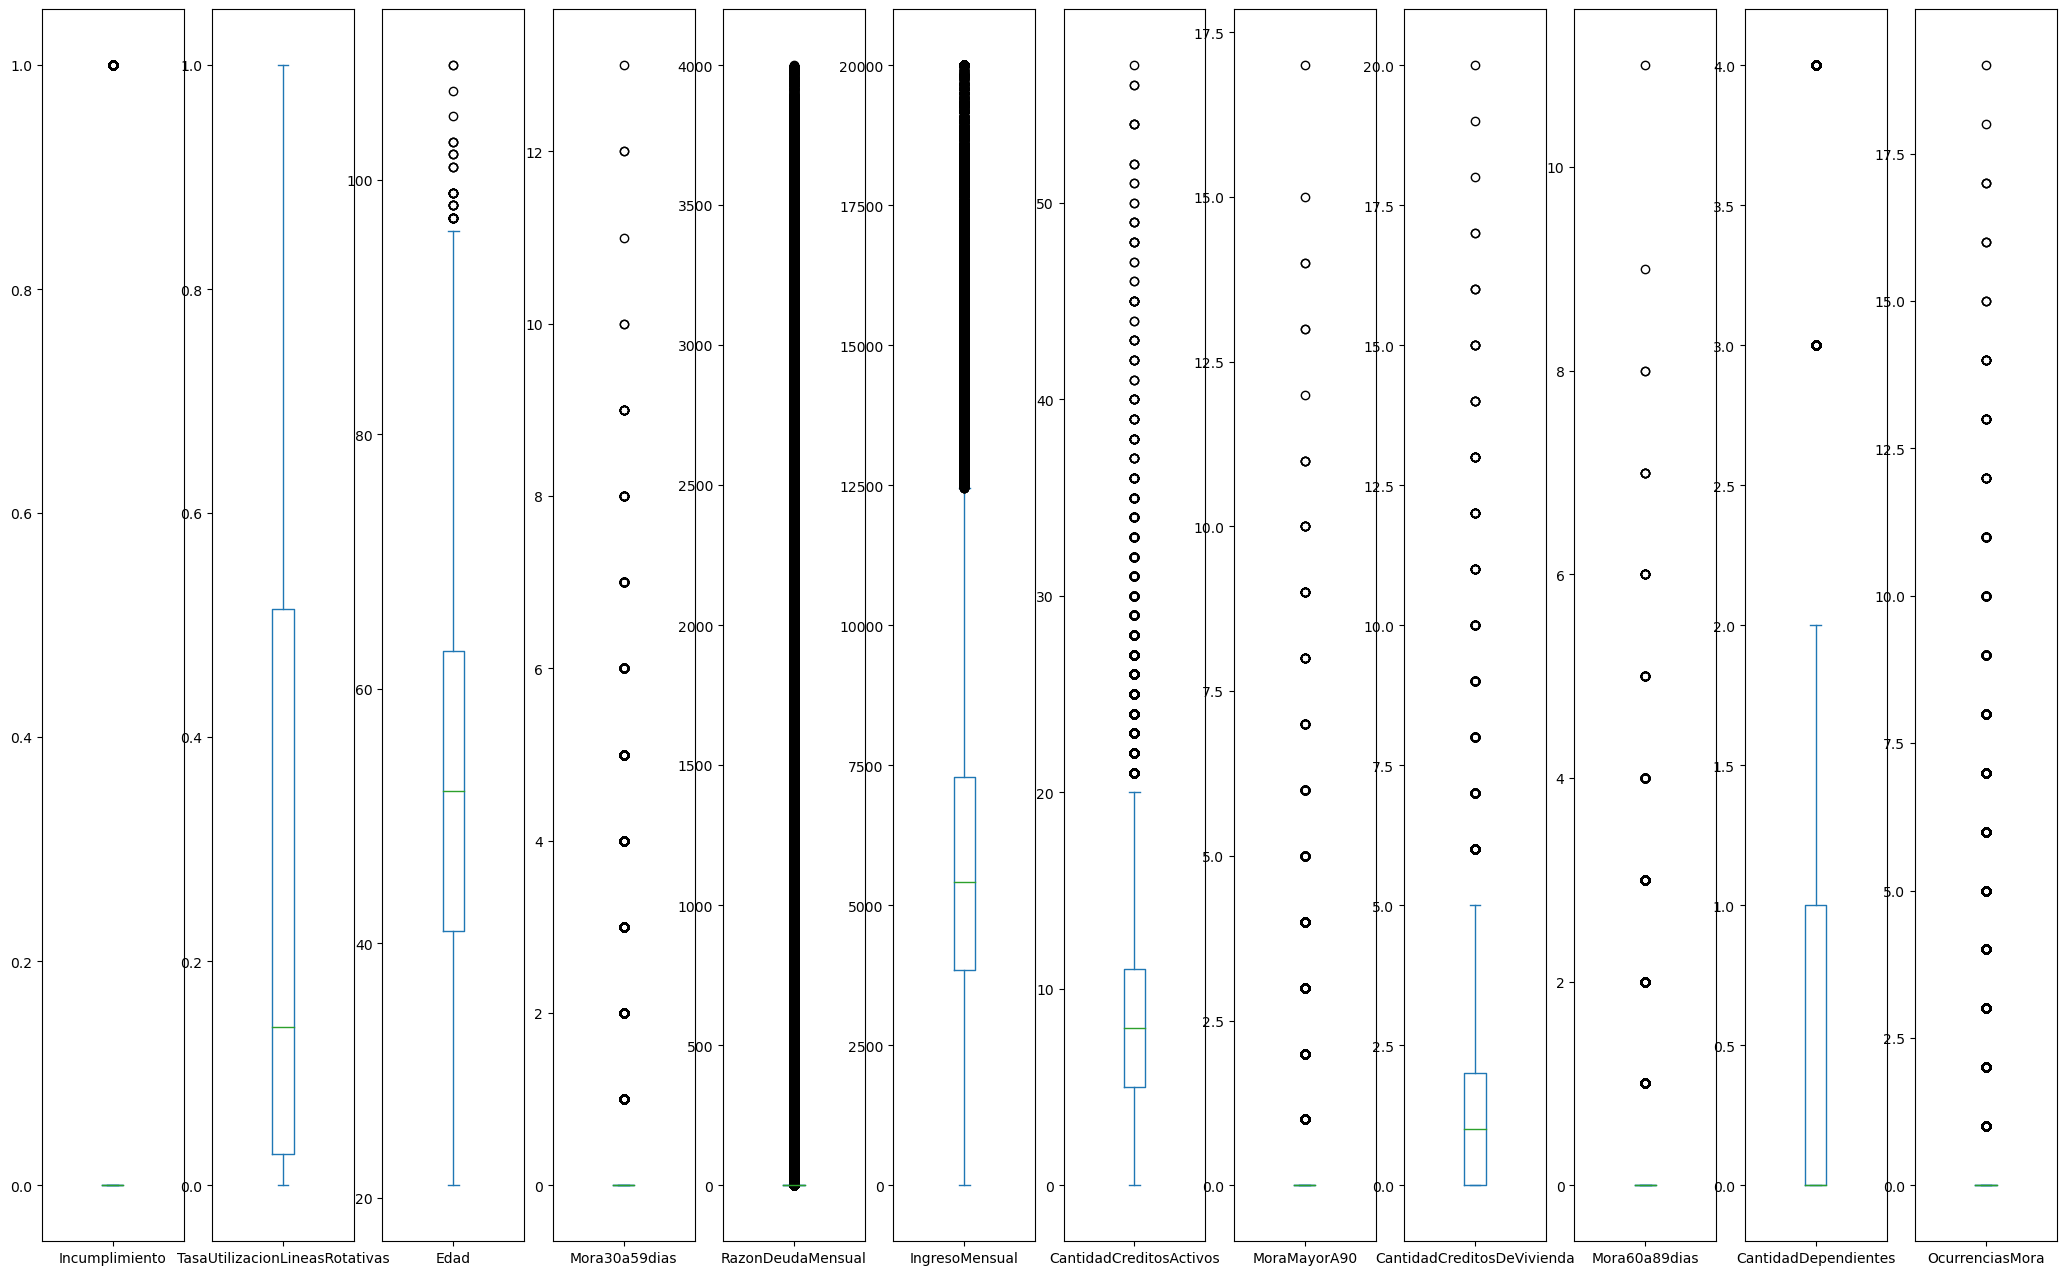

In [99]:
d.plot(kind='box',subplots=True, sharey=False, figsize=(26, 16))

Incumplimiento                       Axes(0.125,0.11;0.0545775x0.77)
TasaUtilizacionLineasRotativas    Axes(0.190493,0.11;0.0545775x0.77)
Edad                              Axes(0.255986,0.11;0.0545775x0.77)
Mora30a59dias                     Axes(0.321479,0.11;0.0545775x0.77)
RazonDeudaMensual                 Axes(0.386972,0.11;0.0545775x0.77)
IngresoMensual                    Axes(0.452465,0.11;0.0545775x0.77)
CantidadCreditosActivos           Axes(0.517958,0.11;0.0545775x0.77)
MoraMayorA90                      Axes(0.583451,0.11;0.0545775x0.77)
CantidadCreditosDeVivienda        Axes(0.648944,0.11;0.0545775x0.77)
Mora60a89dias                     Axes(0.714437,0.11;0.0545775x0.77)
CantidadDependientes               Axes(0.77993,0.11;0.0545775x0.77)
OcurrenciasMora                   Axes(0.845423,0.11;0.0545775x0.77)
dtype: object

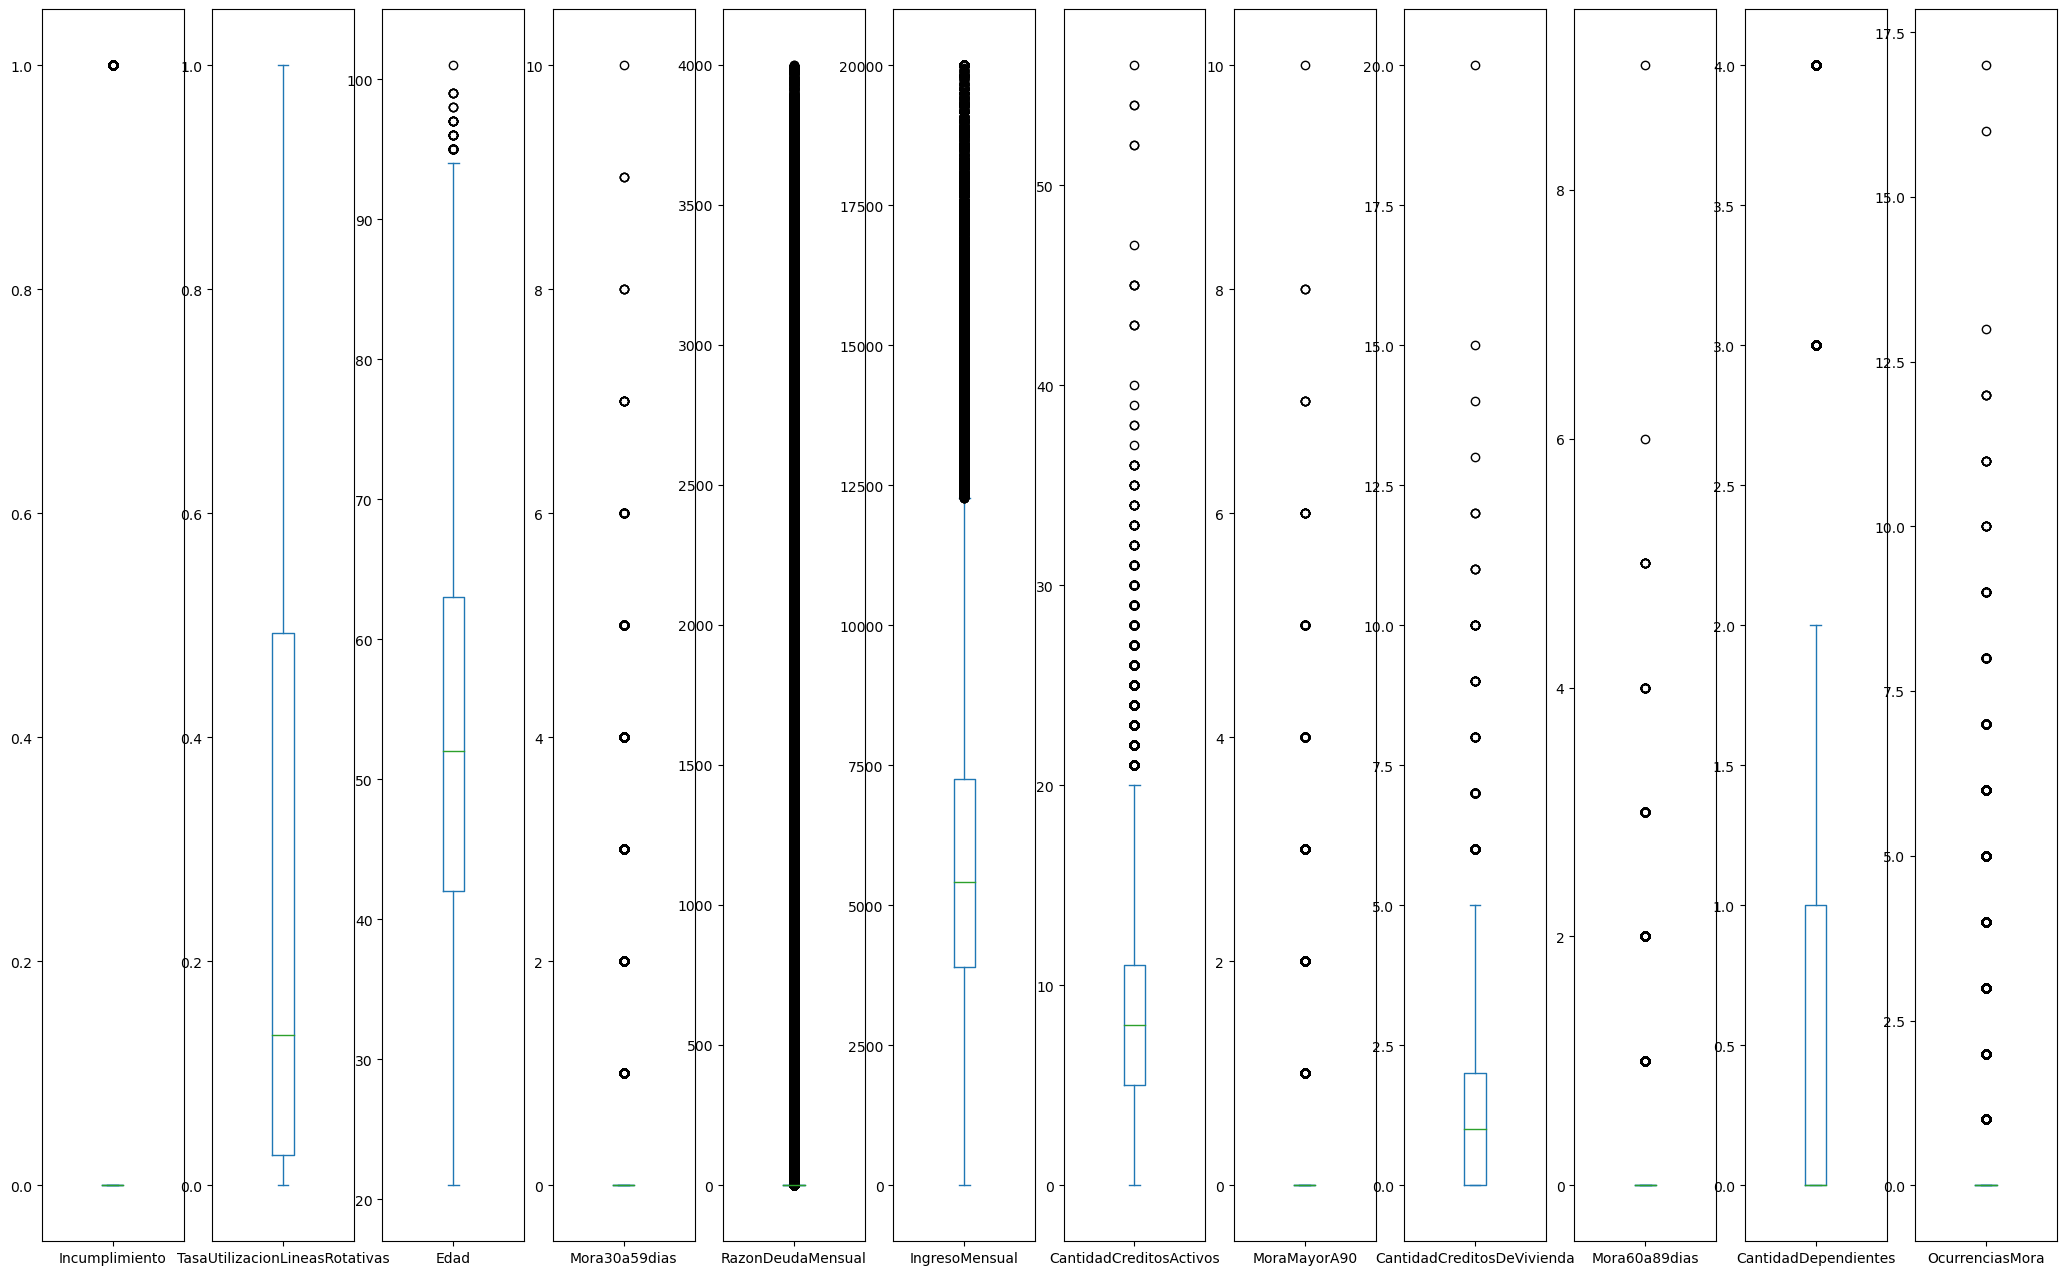

In [100]:
df.plot(kind='box',subplots=True, sharey=False, figsize=(26, 16))


In [101]:
df.describe()

,Incumplimiento,TasaUtilizacionLineasRotativas,Edad,Mora30a59dias,RazonDeudaMensual,IngresoMensual,CantidadCreditosActivos,MoraMayorA90,CantidadCreditosDeVivienda,Mora60a89dias,CantidadDependientes,OcurrenciasMora
count,127126.000000,127126.000000,127126.000000,127126.000000,127126.000000,127126.000000,127126.000000,127126.000000,127126.000000,127126.000000,127126.000000,127126.000000
mean,0.052240,0.293172,52.480209,0.191102,248.267380,5933.947926,8.267593,0.056590,0.963894,0.044389,0.692038,0.292080
std,0.222511,0.332155,14.644336,0.561956,701.232209,3307.270204,4.773128,0.321047,0.978246,0.247139,1.023520,0.811771
min,0.000000,0.000000,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.027338,42.000000,0.000000,0.177814,3900.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.134533,52.000000,0.000000,0.364308,5416.000000,8.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,0.493314,63.000000,0.000000,0.814114,7250.000000,11.000000,0.000000,2.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,101.000000,10.000000,3999.000000,20000.000000,56.000000,10.000000,20.000000,9.000000,4.000000,17.000000


In [25]:
# Exportar df a csv
nombre_archivo = 'data/Preprocessed.csv'

df.to_csv(nombre_archivo, index=False)